# fast neural style  基于VGG16的快速图像风格化

In [14]:
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

## 引入matplotlib库，实现可视化输出

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images_side_by_side(original_image_path, stylized_image_path, title1='Original Image', title2='Stylized Image'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 创建一个包含两个子图的图形
    
    # 加载并显示原始图像
    original_img = mpimg.imread(original_image_path)
    axs[0].imshow(original_img)
    axs[0].set_title(title1)
    axs[0].axis('off')  # 不显示坐标轴

    # 加载并显示风格化后的图像
    stylized_img = mpimg.imread(stylized_image_path)
    axs[1].imshow(stylized_img)
    axs[1].set_title(title2)
    axs[1].axis('off')  # 不显示坐标轴
    
    plt.show()


## 修改训练函数
首先，导入所需库，并准备一个简单的绘图函数来实时更新训练损失。

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def plot_losses(epochs, content_losses, style_losses, total_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, content_losses, label='Content Loss')
    plt.plot(epochs, style_losses, label='Style Loss')
    plt.plot(epochs, total_losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Time')
    plt.show()


## 检查路径函数
此函数检查和创建存储模型的目录。

In [17]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):  # 如果存储模型的目录不存在
            os.makedirs(args.save_model_dir)  # 创建目录
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)  # 创建检查点目录
    except OSError as e:
        print(e)    
        sys.exit(1)  # 出错则退出程序


## 训练函数
此函数封装了整个训练流程。

In [18]:
def train(args):
    device = torch.device("cuda" if args.cuda else "cpu")
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()
    vgg = Vgg16(requires_grad=False).to(device)

    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = utils.load_image(args.style_image, size=args.style_size)
    style = style_transform(style).repeat(args.batch_size, 1, 1, 1).to(device)
    features_style = vgg(utils.normalize_batch(style))
    gram_style = [utils.gram_matrix(y) for y in features_style]

    content_losses, style_losses, total_losses, epochs = [], [], [], []

    for e in range(args.epochs):
        transformer.train()
        epoch_content_loss, epoch_style_loss, count = 0.0, 0.0, 0

        with tqdm(total=len(train_loader), desc=f'Epoch {e + 1}/{args.epochs}', unit='batch') as pbar:
            for batch_id, (x, _) in enumerate(train_loader):
                n_batch = len(x)
                count += n_batch
                optimizer.zero_grad()
                x = x.to(device)
                y = transformer(x)

                y = utils.normalize_batch(y)
                x = utils.normalize_batch(x)

                features_y = vgg(y)
                features_x = vgg(x)

                content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
                style_loss = 0.
                for ft_y, gm_s in zip(features_y, gram_style):
                    gm_y = utils.gram_matrix(ft_y)
                    style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
                style_loss *= args.style_weight

                total_loss = content_loss + style_loss
                total_loss.backward()
                optimizer.step()

                epoch_content_loss += content_loss.item() * n_batch
                epoch_style_loss += style_loss.item() * n_batch

                pbar.update(1)

        # 记录每个epoch的平均损失
        epoch_content_loss /= len(train_dataset)
        epoch_style_loss /= len(train_dataset)
        epoch_total_loss = epoch_content_loss + epoch_style_loss
        content_losses.append(epoch_content_loss)
        style_losses.append(epoch_style_loss)
        total_losses.append(epoch_total_loss)
        epochs.append(e + 1)

        # 更新绘图
        plot_losses(epochs, content_losses, style_losses, total_losses)


## 风格化函数
用于将已训练的模型应用于新的内容图像，实现风格转换。

In [19]:
def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = utils.load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if args.model.endswith(".onnx"):
        output = stylize_onnx(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)
            style_model.eval()
            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx, opset_version=11).cpu()            
            else:
                output = style_model(content_image).cpu()

    # 保存并显示图像
    utils.save_image(args.output_image, output[0])
    show_images_side_by_side(args.content_image, args.output_image)


## ONNX风格化函数
使用ONNX运行时进行风格化处理。

In [20]:
def stylize_onnx(content_image, args):
    """
    Read ONNX model and run it using onnxruntime
    """

    assert not args.export_onnx

    import onnxruntime

    ort_session = onnxruntime.InferenceSession(args.model)

    def to_numpy(tensor):
        return (
            tensor.detach().cpu().numpy()
            if tensor.requires_grad
            else tensor.cpu().numpy()
        )

    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(content_image)}
    ort_outs = ort_session.run(None, ort_inputs)
    img_out_y = ort_outs[0]

    return torch.from_numpy(img_out_y)


## 主函数
解析命令行参数，根据用户选择执行训练或风格化。

In [21]:
def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2,
                                  help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000,
                                  help="number of batches after which a checkpoint of the trained model will be created")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="path to content image you want to stylize")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--cuda", type=int, default=False,
                                 help="set it to 1 for running on cuda, 0 for CPU")
    eval_arg_parser.add_argument("--export_onnx", type=str,
                                 help="export ONNX model to a given file")
    eval_arg_parser.add_argument('--mps', action='store_true', default=False, help='enable macOS GPU training')

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)
    
    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)

## 图像风格化函数

In [22]:
from argparse import Namespace

def stylize_image(content_image, model, output_image, cuda, content_scale=None, export_onnx=None):
    args = Namespace(
        content_image=content_image,
        model=model,
        output_image=output_image,
        cuda=cuda,
        content_scale=content_scale,
        export_onnx=export_onnx
    )

    # 调用原先的 stylize 函数
    stylize(args)



## 图像风格化训练函数

In [23]:
from argparse import Namespace

def train_model(dataset, style_image, save_model_dir, epochs, cuda):
    args = Namespace(
        dataset=dataset,
        style_image=style_image,
        save_model_dir=save_model_dir,
        epochs=epochs,
        cuda=cuda,
        batch_size=4,  # 可以根据需要设置默认值
        lr=1e-3,       # 学习率默认值
        content_weight=1e5,
        style_weight=1e10,
        image_size=256,
        style_size=None,
        seed=42,
        checkpoint_model_dir=None,  # 如果需要可以提供
        log_interval=500,
        checkpoint_interval=2000
    )
    
    # 检查并创建必要的目录
    check_paths(args)
    
    # 执行训练
    train(args)



/home/yuwenhan/anaconda3/envs/image_enhance/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/2:   0%|          | 0/20696 [00:00<?, ?batch/s]/home/yuwenhan/anaconda3/envs/image_enhance/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/2: 100%|██████████| 20696/20696 [29:35<00:00, 11.65batch/s] 


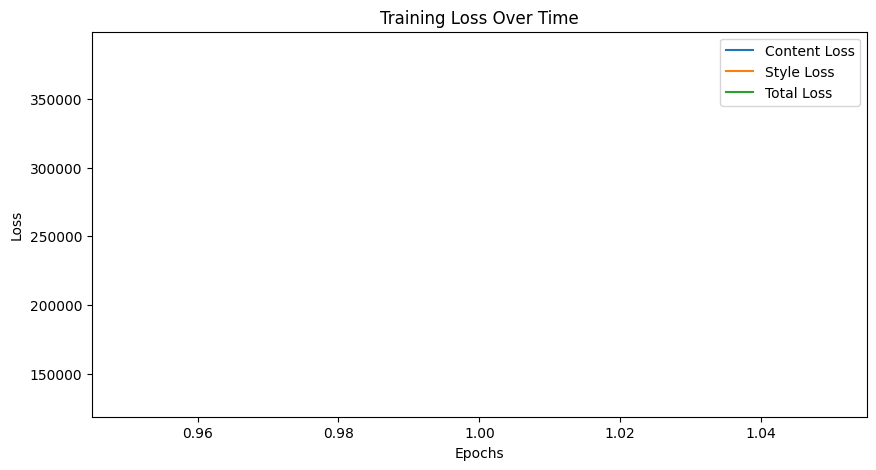

Epoch 2/2: 100%|██████████| 20696/20696 [30:22<00:00, 11.36batch/s] 


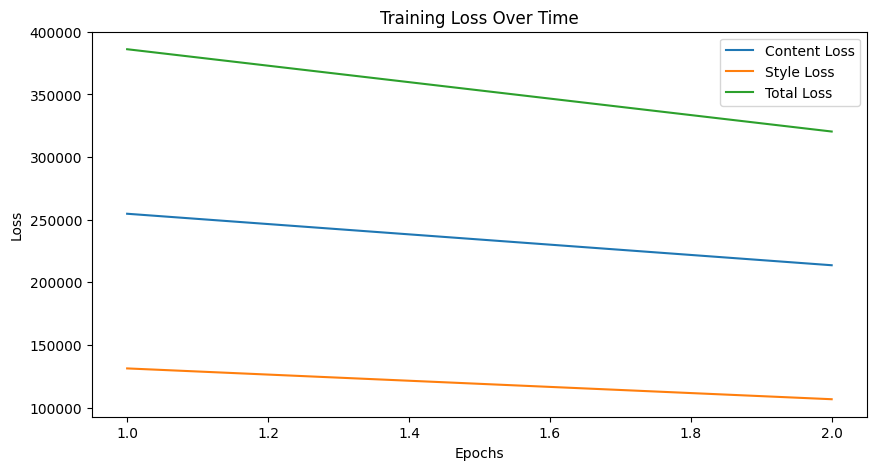

In [24]:
if __name__ == "__main__":
    '''
    stylize_image(
        content_image="../images/content_images/amber.jpg",
        model="../new_saved_models/Monet.model",
        output_image="../images/output_images/amber-monet.jpg",
        cuda=1
    )
    '''
    train_model(
        dataset='../../train', # 设置数据集位置
        style_image='../images/style_images/cartoon.png', # 设置风格化位置
        save_model_dir='../new_saved_models', # 设置文件保存位置
        epochs=2,
        cuda=1
    )
        
